In [1]:
import cv2 as cv
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# TEACHER SIDE

In [2]:
def save_frame(frame, cnt):
    mask = cv.inRange(frame, (0, 255, 0), (0, 255,0))
    ## slice the green
    imask = mask>0
    green = np.zeros_like(frame, np.uint8)
    green[imask] = frame[imask]
    cv.imwrite(folder_path+'frame{:d}.jpg'.format(cnt), green)

In [3]:
folder_name = "frames\\"
current_path = os.getcwd()
folder_path = os.path.join(current_path, folder_name)

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
# Read the network into Memory
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [6]:
cap = cv.VideoCapture(0)
cnt = 0
count = 0
seq = []
fourcc = cv.VideoWriter_fourcc(*'XVID')
outt = cv.VideoWriter('frames\output.avi',fourcc, 20.0, (640,480))

while (not (cv.waitKey(1) & 0xFF == ord('q'))):
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    
    inWidth = 168

    inHeight = 168
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > 0.2 else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    fps = cap.get(cv.CAP_PROP_FPS)
    
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    cv.imshow('Dance Tutorial', frame)
    count+=1
    if(count == fps*2):
        count=0
        cnt+=1
        save_frame(frame, cnt)
        seq.append(frame)
        outt.write(frame)
        print("CAPTURED!")
        
cap.release()
cv.destroyAllWindows()    
outt.release()

CAPTURED!
CAPTURED!
CAPTURED!
CAPTURED!
CAPTURED!
CAPTURED!
CAPTURED!


# STUDENT SIDE (BONUS)

In [7]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [8]:
def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True)
    # setup the figure
    fig = plt.figure()
    plt.title(title, fontsize = 8) 
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB)
    plt.axis("off")
    # show the images
    plt.show()

In [9]:
# load the images -- the original, the original + contrast,
# and the original + photoshop
original = cv.imread("frame2.jpg")
contrast = cv.imread("frame1.jpg")
# convert the images to grayscale
#original = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
#contrast = cv.cvtColor(contrast, cv.COLOR_BGR2GRAY)

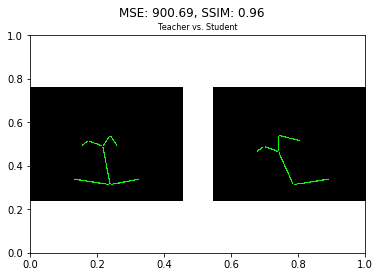

In [10]:
compare_images(original, contrast, "Teacher vs. Student")